# IMPORTANT NOTES BEFORE RUNNING:
* Change runtime type to "GPU" to train on colab
* Download TACO's .h5 from https://github.com/pedropro/TACO/releases/tag/1.0 (we used taco_10_3.zip) to ```/Taco-Mask```
* Recommend using google drive as you won't lose progress when runtime disconnects
* We used a different github we created that uses tensorflow 1.x, since as of now (summer 2021), you cannot train on tensorflow 2.x

In [ ]:
# Only clone once and drag "/Taco-Mask" into "/MyDrive" after next block
!git clone https://github.com/abbesmoe/Taco-Mask

In [ ]:
# Suggestion: Use google drive so everything auto saves and you dont lose progress
from google.colab import drive

drive.mount('/content/gdrive')

In [1]:
# We are using older versions of keras and tensorflow to train
!pip install keras==2.1.6
!pip install 'h5py==2.10.0'

In [2]:
# Selects tensorflow version 1.15
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [3]:
# Change directory to /detector
%cd /content/gdrive/MyDrive/Taco-Mask/TACO/detector

/content/gdrive/MyDrive/Taco-Mask/TACO/detector


In [4]:
# Import packages
%matplotlib inline
import csv
import dataset
import json
import matplotlib.pyplot as plt
import model as modellib
import numpy as np
import os
import pandas as pd
import skimage.io
import visualize
from config import Config
from os import path
from PIL import Image

Using TensorFlow backend.


In [ ]:
# This installs TACOs original 1500 images (find them under /TACO/data)
!python3 ../download.py

# Train Dataset

In [5]:
# Run to split dataset into test/train/val sets used for training
!python3 split_dataset.py --dataset_dir ../data --nr_trials 1

In [ ]:
# Train a new model starting from pre-trained coco weights on train set split #0
!python3 -W ignore detector.py train --model=coco --dataset=../data --class_map=./taco_config/map_10.csv --round 0

In [ ]:
# Continue training from the last epoch complete
!python3 -W ignore detector.py train  --dataset=../data --model="Name of folder in models" --class_map=./taco_config/map_10.csv --round 0 --lrate=0.01

# Test new weights

In [5]:
# check class names
# The map is what has all category names.
# The file has categories on the left side and super categories on the right
# which combines multiple categories into one to help create weights
# for categories with not a lot of annotations.
class_map = {}
with open("taco_config/map_10.csv") as csvfile:
    reader = csv.reader(csvfile)
    class_map = {row[0]:row[1] for row in reader}

TACO_DIR = "../data/"
round = None 
subset = "train"
dataset = dataset.Taco()
taco = dataset.load_taco(TACO_DIR, round, subset, class_map=class_map, return_taco=True)

dataset.prepare()

print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

creating index...
index created!
Number of images used: 1500
Class Count: 11
  0. BG                                                
  1. Bottle                                            
  2. Bottle cap                                        
  3. Can                                               
  4. Cigarette                                         
  5. Cup                                               
  6. Lid                                               
  7. Other                                             
  8. Plastic bag + wrapper                             
  9. Pop tab                                           
 10. Straw                                             


In [6]:
# Create config class and override hyperparameters
# Changed images per gpu so it runs smoother
class TacoTestConfig(Config):
  NAME = "taco"
  GPU_COUNT = 1
  IMAGES_PER_GPU = 1
  NUM_CLASSES = dataset.num_classes

config = TacoTestConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_CLASSLESS_NMS_THRESHOLD 0.9
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
DETECTION_SCORE_RATIO          True
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                23
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MASK_SHARE 

In [8]:
# Create a model in inference mode (so it will run detection and
# not be on the other option "training") and using our config class
# then load the trained weights
# The weights are what predicts the object
model = modellib.MaskRCNN(mode="inference", model_dir='mask_rcnn_taco.hy',
                          config=config)

# Change path to look into the folder created in models/logs/file.h5
model.load_weights('models/mask_rcnn_taco_0100.h5',
                   by_name=True, weights_out_path=None)

In [9]:
# Create list of class names mapped to this .h5 file
# If running a different map, grab class names from right column (make sure to add BG)
class_names = ["BG","Bottle","Bottle cap","Can","Cigarette","Cup",
               "Lid","Other","Plastic bag + wrapper","Pop tab","Straw"]

In [10]:
# Select an image to test. Store in in /uploaded_images

imagePath = "../../uploaded_images/"
imageName = "bottle.jpg" # you can 
img = Image.open(os.path.join(imagePath, imageName))

fileName = os.path.splitext(imageName)[0]
fileExtension = os.path.splitext(imageName)[1]

# If statement to catch any non .jpg file and then save it as one
if fileExtension != '.jpg':
  img.convert('RGB').save("{}{}.jpg".format(imagePath, fileName))
  imageName = "{}.jpg".format(fileName)

image = skimage.io.imread(os.path.join(imagePath, imageName))

In [11]:
# run detection on the uploaded image
r = model.detect([image], verbose=0)[0]

In [12]:
# This function grabs all data that was found in detection
def min_accuracy(r, a):
  result = {'rois': [], 'masks': [], 'class_ids': [], 'scores': []}
  indecies = []
  for i,ele in enumerate(r['scores']):
    # It then compares the accuracy scores with the given score and
    # displays the ones >= a
    if ele >= a:
      result['rois'].append(r['rois'][i])
      result['class_ids'].append(r['class_ids'][i])
      result['scores'].append(r['scores'][i])
      indecies.append(i)
  
  result['masks'] = r['masks'][:,:,indecies]

  result['rois'] = np.asarray(result['rois'])
  result['masks'] = np.asarray(result['masks'])
  result['class_ids'] = np.asarray(result['class_ids'])
  result['scores'] = np.asarray(result['scores'])
  return result

# Set your custom min accuracy down here
r = min_accuracy(r, 0.7)
print(r['class_ids'])

[1 2]


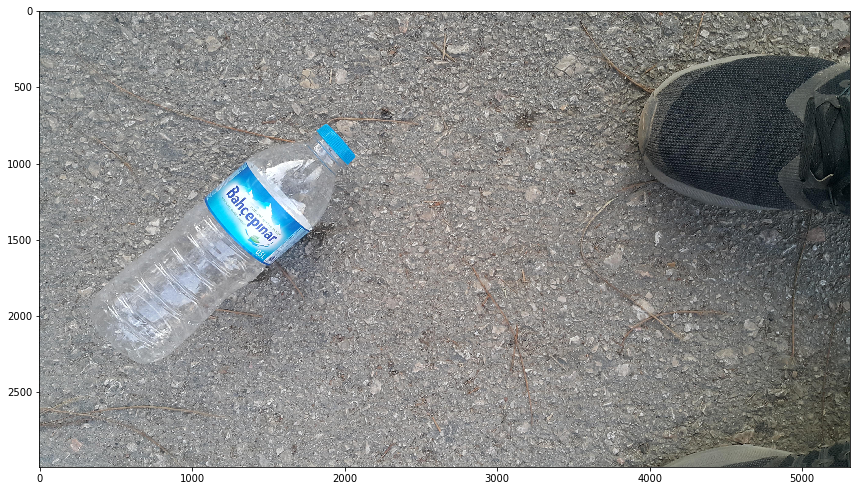

In [13]:
# Display original image
plt.figure(figsize=(12,10))
skimage.io.imshow(image)

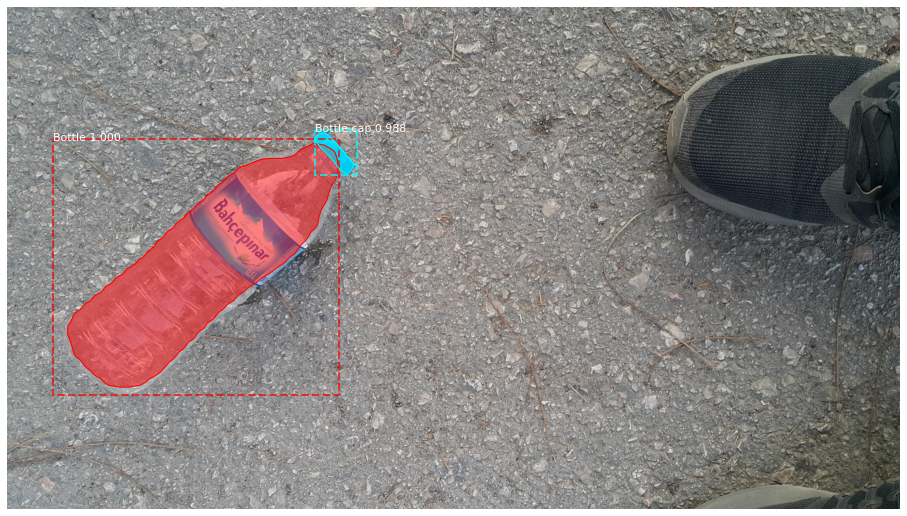

In [15]:
# Display annotated image
# This function also saves the image as a .jpg and stores it
# in /annotated_images
visualize.display_instances(image, imageName, r['rois'], r['masks'],
                            r['class_ids'], class_names, r['scores'])